In [270]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from dotenv import load_dotenv
import seaborn as sns
from datetime import time
warnings.filterwarnings('ignore')
load_dotenv()

True

In [271]:
DayAhead_dir = './Result/DayAhead_09-01_09-30_num20_sim_v0/3' # result of DayAhead strategy
GB_MARL_dir = './Result/GB-MARL-v2_alpha0.5_beta0.1_num20_s0/17' # result of GB-MARL strategy
MADDPG_dir = './Results/MADDPG_07-01_09-01_20_sim_v0/3' # result of MADDPG strategy
VDN_dir = './Result/VDN-MARL_alpha0.5_beta0.1_num20_sim_v0/1' # result of Multi-Agent VDN strategy
IQL_dir = './Result/IQL-MARL_07-01_09-01_20_sim_v0/1' # result of Muti-Agent IQL strategy
DDPG_dir = './Result/DDPG_alpha0.5_beta0.1_20_sim_v0/2' # result of DDPG strategy
Random_dir = './Result/RandomPower_09-01_09-30_20_sim_v0/1' # result of Random strategy
Unschedule_dir = './Result/Unschedule_09-01_09-30_20_sim_v0/1' # result of Unschedule strategy

result_dir = RESULT_DIR = GB_MARL_dir # To display the result of charging strategy and the power consumption of EVs in the charging station 

# set the path to the files containing the charging records, building loading history, and SoC history
test_charging_file = '/test_charging_records.csv'
test_building_file = '/test_building_loading_history.csv'
test_soc_file = '/test_soc_history.csv'

# set the path of training files containing the charging records, building loading history, and SoC history
building_file = '/building_loading_history.csv'
soc_file = '/soc_history.csv'
charging_file = '/charging_records.csv'

## 充電/放電過程 & 原始負載與 EV 充放電後的負載變化圖

In [272]:
# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID, soc_history_file_path):
    """
    Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
    args:
    - requestID: int, the requestID for which to plot the SoC, SoC_upper_bound, and SoC_lower_bound
    - soc_history_file_path: str, the path to the csv file containing the SoC history data
    """

    data = pd.read_csv(soc_history_file_path) # use pandas to read the csv file
    data['current_time'] = pd.to_datetime(data['current_time']) # use pandas to_datetime to convert the 'current_time' column to datetime
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout() # Adjust the plot to ensure everything fits without overlapping
    
    plt.show()

In [273]:
def plot_load_history(file_path, start_date, end_date):
    """
    Function to plot the original load and total load after charging/discharging for a given date range.
    args:
    - file_path: str, path to the CSV file containing the load history
    - start_date: str, start date for the date range
    - end_date: str, end date for the date range
    """
    # Convert start_date and end_date to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time']) # parse_dates to convert 'current_time' to datetime
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    bar_positions = range(len(filtered_df))
    
    # set bar positions and width for original load and total load
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    # set x-axis labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [274]:
# # Plot SoC for a given requestID
# request_id = REQUEST_ID = 20180901001 # Replace with the desired requestID
# soc_history_file_path = result_dir + '/test_soc_history.csv'
# plot_soc_for_requestID(request_id, soc_history_file_path)  

# # Plot building load for a given date range
# start_date = START_DATE = '2018-09-01' # Replace with the desired testing start date
# end_date = END_DATE = '2018-09-02' # Replace with the desired testing end date
# building_load_file_path = result_dir + 'test_building_loading_history.csv'  # Modify this to the path of your load history file
# plot_load_history(building_load_file_path, start_date=start_date, end_date=end_date)

## 計算建物電力成本

In [275]:
def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    """
    Function to set the real-time price range for a given start and end time
    args:
    - real_time_price: pd.DataFrame, the DataFrame containing the real-time price data
    - start_time: datetime, the start time for the price range
    - end_time: datetime, the end time for the price range
    returns:
    - pd.DataFrame, the real-time price data for the specified time range
    """
    real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

In [276]:
# set testing start time and testing end time
start_datetime_str = START_DATETIME_STR = '2018-09-01'
end_datetime_str = END_DATETIME_STR = '2018-09-30'

# convert string to datetime
start_datetime = START_DATE_TIME = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = END_DATE_TIME = datetime.strptime(end_datetime_str, '%Y-%m-%d')

# set contract capacity and capacity price
contract_capacity = CONTRACT_CAPACITY  = 700
capacity_price = CAPACITY_PRICE = 15
real_time_price_path = REAL_TIME_PRICE_PATH = './Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv'
# get real time price data
real_time_price = pd.read_csv(REAL_TIME_PRICE_PATH)
real_time_price = set_real_time_price_range(real_time_price, start_datetime, end_datetime)

# get building loading history result data
DayAhead_building_file = DayAhead_dir + building_file
GB_MARL_building_file = GB_MARL_dir + test_building_file
MADDPG_building_file = MADDPG_dir + test_building_file
VDN_building_file = VDN_dir + test_building_file
IQL_building_file = IQL_dir + test_building_file
DDPG_building_file = DDPG_dir + test_building_file
Random_building_file = Random_dir + building_file
Unschedule_building_file = Unschedule_dir + building_file

# set file paths and method names
methods = [DayAhead_building_file, GB_MARL_building_file, MADDPG_building_file, VDN_building_file, IQL_building_file, DDPG_building_file, Random_building_file, Unschedule_building_file]
method_names = METHOD_NAMES = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
colors = COLORS = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']
data_frames = DATA_FRAMES = [pd.read_csv(method) for method in methods]

In [277]:
def calculate_cost_and_penalty_v1(df, real_time_price, start_time, end_time):
    """
    Function to calculate total cost and overload penalty for a given date range.
    args:
    - df: DataFrame, the building load data
    - real_time_price: DataFrame, the real-time price data
    - start_time: datetime, the start time for the date range
    - end_time: datetime, the end time for the date range
    returns:
    - DataFrame, the building load data with cost and price data
    - float, the total cost for the specified date range
    - float, the total overload penalty for the specified date range
    """
    
    # filter data by start and end time
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # filter data by hour (7:00 - 23:00)
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # merge real time price data
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # calculate cost
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # calculate total cost
    current_tariff = df_filtered['cost'].sum()

    # calculate overload penalty
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    # calculate overload penalty for each month
    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > CONTRACT_CAPACITY:
            overload -= CONTRACT_CAPACITY
            overload_penalty += min(overload, CONTRACT_CAPACITY * 0.1) * CAPACITY_PRICE * 2  # between 0% and 10% of contract capacity
            overload -= min(overload, CONTRACT_CAPACITY * 0.1)
            overload_penalty += overload * CAPACITY_PRICE * 3  # more than 10% of contract capacity
        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)

    return df_filtered, current_tariff, total_overload_penalty

In [278]:
def calculate_cost_and_penalty_v2(df, real_time_price, start_time, end_time):
    # filter data by start and end time
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # filter data by hour (7:00 - 23:00)
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # merge filtered data and real time price data by current_time and datetime with left join
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # calculate cost
    df_filtered['within_capacity_load'] =  df_filtered['total_load'].clip(upper=CONTRACT_CAPACITY) # Load within contract capacity
    df_filtered['cost_within_capacity'] = df_filtered['within_capacity_load'] * df_filtered['average_price']
    
    # Calculate total cost (only within capacity)
    current_tariff = df_filtered['cost_within_capacity'].sum()

    # Calculate overload penalty
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    # Calculate overload penalty for each month
    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > CONTRACT_CAPACITY:
            overload -= CONTRACT_CAPACITY
            overload_penalty += min(overload, CONTRACT_CAPACITY * 0.1) * CAPACITY_PRICE * 2  # between 0% and 10% of contract capacity
            overload -= min(overload, CONTRACT_CAPACITY * 0.1)
            overload_penalty += overload * CAPACITY_PRICE * 3  # more than 10% of contract capacity
        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)

    return df_filtered, current_tariff, total_overload_penalty

In [279]:
def show_total_cost(method_names, total_costs, colors):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

    # add labels and title
    ax.set_xlabel('Method', fontsize=10, fontweight='bold')
    ax.set_ylabel('Total Cost (USD)', fontsize=10, fontweight='bold')
    ax.set_title('Total Electricity Cost Comparison by Method', fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    # display total cost on top of each bar and print the value
    print('Total Cost:')
    print('---------------------------------')
    for bar, yval in zip(bars.patches, total_costs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
                f'${height:.4f}', ha='center', va='bottom', fontsize=10)
        print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')
    print('---------------------------------')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

def show_overload_penalty(method_names, overload_penalties, colors):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

    # add labels and title
    ax.set_xlabel('Method', fontsize=10, fontweight='bold')
    ax.set_ylabel('Overload Penalty (USD)', fontsize=10, fontweight='bold')
    ax.set_title('Overload Penalty Comparison by Method', fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    # display overload penalty on top of each bar and print the value
    print("Overload Penalties:")
    print('---------------------------------')
    for bar, yval in zip(bars.patches, overload_penalties):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
                f'${height:.4f}', ha='center', va='bottom', fontsize=10)
        print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')
    print('---------------------------------')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

def show_current_tarriff(method_names, current_tariffs, colors):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

    ax.set_xlabel('Method', fontsize=10, fontweight='bold')
    ax.set_ylabel('Current Tariff (USD)', fontsize=10, fontweight='bold')
    ax.set_title('Current Tariff Comparison by Method', fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    print('Current Tariffs:')
    print('---------------------------------')
    for bar, yval in zip(bars.patches, current_tariffs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
                f'${height:.2f}', ha='center', va='bottom', fontsize=12)
        print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')
    print('---------------------------------')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

Total Cost:
---------------------------------
DayAhead: $5955.8663
GB-MARL: $8295.4404
MADDPG: $7956.4739
MARL-VDN: $8413.6138
MARL-IQL: $11798.6897
DDPG: $7456.4051
RandomPower: $10302.0869
Unschedule: $11402.6873
---------------------------------


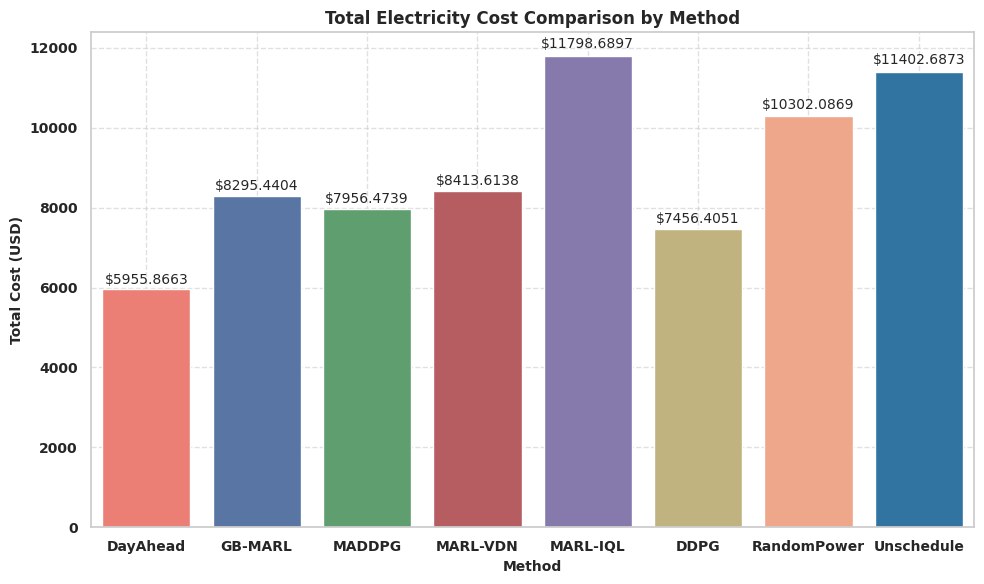

Overload Penalties:
---------------------------------
DayAhead: $0.0000
GB-MARL: $2235.9199
MADDPG: $1876.4515
MARL-VDN: $2271.3258
MARL-IQL: $5643.1583
DDPG: $1333.7160
RandomPower: $4172.6238
Unschedule: $5221.6263
---------------------------------


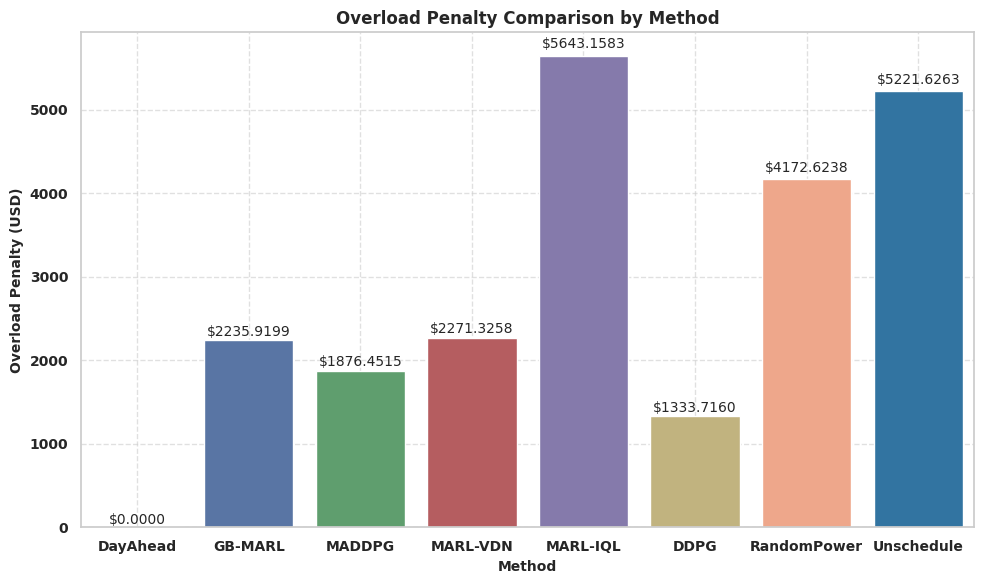

In [280]:
# calculate cost and penalty for each method
total_costs, overload_penalties, current_tariffs = [], [], []
for df, method_name in zip(DATA_FRAMES, METHOD_NAMES):
    df_filtered, current_tariff, total_overload_penalty = calculate_cost_and_penalty_v1(df, real_time_price, START_DATE_TIME, END_DATE_TIME)
    total_cost = current_tariff + total_overload_penalty  # add overload penalty to total cost
    total_costs.append(total_cost) # append total cost to the list
    overload_penalties.append(total_overload_penalty) # append overload penalty to the list
    current_tariffs.append(current_tariff) # append current tariff to the list
    
show_total_cost(METHOD_NAMES, total_costs, COLORS)
show_overload_penalty(METHOD_NAMES, overload_penalties, COLORS)
# show_current_tarriff(method_names, current_tariffs, colors)

## 計算峰谷比 (PVR)

In [281]:
def show_peak_to_valley_ratio(method_names, peak_to_valley_ratios, colors):
    # set the style of the plot
    sns.set(style="whitegrid")

    # plot peak-to-valley ratio bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = sns.barplot(x=method_names, y=peak_to_valley_ratios, palette=colors, ax=ax)

    # add labels and title
    ax.set_xlabel('Method', fontsize=10, fontweight='bold')
    ax.set_ylabel('Peak-to-Valley Ratio', fontsize=10, fontweight='bold')
    ax.set_title('Peak-to-Valley Ratio Comparison by Method (07:00 to 23:00)', fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)

    # display peak-to-valley ratio on top of each bar
    for bar, yval in zip(bars.patches, peak_to_valley_ratios):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=10)

    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()

    plt.show()


In [282]:
# peak_to_valley_ratios = []
# print('Peak-to-Valley Ratios:')
# print('---------------------------------')
# for df, method_name in zip(DATA_FRAMES, METHOD_NAMES):
#     # filter data by date range
#     df['current_time'] = pd.to_datetime(df['current_time'])
#     df_filtered_dates = df[(df['current_time'] >= START_DATE_TIME) & (df['current_time'] < END_DATE_TIME)].copy()
    
#     peak_to_valley_ratios_days = []
    
#     for day in df_filtered_dates['current_time'].dt.day.unique():
#         df_filtered = df_filtered_dates[df_filtered_dates['current_time'].dt.day == day].copy()
#         df_filtered = df_filtered[(df_filtered['current_time'].dt.time >= time(7, 0, 0)) & (df_filtered['current_time'].dt.time <= time(23, 0, 0))].copy()
#         peak_load, valley_load = min(df_filtered['total_load'].max(), 1000), max(df_filtered['total_load'].min(), 1)
#         peak_to_valley_ratio = peak_load / valley_load
#         peak_to_valley_ratios_days.append(peak_to_valley_ratio)

#     peak_to_valley_ratio = sum(peak_to_valley_ratios_days) / len(peak_to_valley_ratios_days)
#     peak_to_valley_ratios.append(peak_to_valley_ratio)
#     print(f'{method_name}: {peak_to_valley_ratio:.4f}')
# print('---------------------------------')

# show_peak_to_valley_ratio(METHOD_NAMES, peak_to_valley_ratios, COLORS)

## 計算滿意度 (Satisfication Score)

In [283]:
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file

DayAhead_charging_record_file = DayAhead_dir + charging_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_file
Unschedule_charging_record_file = Unschedule_dir + charging_file

methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]
charging_records_methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]
method_names = METHOD_NAMES = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']

In [284]:
def show_satisfaction(method_names, satisfactions, colors):
    sns.set(style="whitegrid")
    # plot average satisfaction bar chart
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=method_names, y=satisfactions, palette=colors)

    # add labels and title
    plt.xlabel('Method', fontsize=10)
    plt.ylabel('Average Satisfaction', fontsize=10)
    plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=12, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)

    # display average satisfaction on top of each bar
    for bar, yval in zip(bars.patches, satisfactions):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

### Satisfication 1

In [285]:
def calculate_midway_satisfaction(df, start_datetime, end_datetime):
    """
    Function to calculate the midway satisfaction for each method
    args:
    - df: DataFrame, the SoC history data
    - start_datetime: datetime, the start datetime for the calculation
    - end_datetime: datetime, the end datetime for the calculation
    returns:
    - Series, the midway satisfaction for each method
    """
    # calculate midway time for each requestID
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    midway_time = midway_time[(midway_time >= start_datetime) & (midway_time < end_datetime)]
    midway_time = midway_time.dt.round('H')
    
    # calculate satisfaction for each requestID
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    
    return pd.Series(satisfaction)

Average Satisfaction 1 by Method:
---------------------------------
DayAhead: 0.6481
GB-MARL: 0.4190
MADDPG: 0.2684
MARL-VDN: 0.5207
MARL-IQL: 0.6214
DDPG: 0.5584
RandomPower: 0.6318
Unschedule: 1.0000


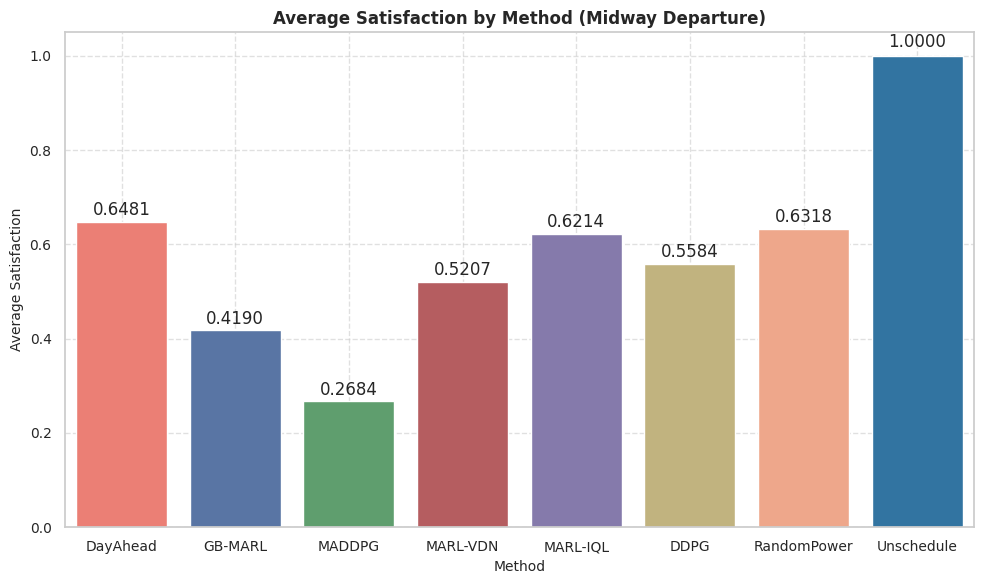

In [286]:
data_frames = DATA_FRAMES = []
for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_datetime, end_datetime)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction 1 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 2

In [287]:
def calculate_midway_satisfaction_2(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]

    # calculate satisfaction2 for each requestID
    satisfaction2 = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = charging_records_df[charging_records_df['requestID'] == requestID]['departure_soc'].values[0]  # SoC at departure (latest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        actual_departure_soc = df[max_time_index]['soc'].values[0]
        satisfaction_value = (actual_departure_soc - soc_initial) / (soc_final - soc_initial) 
        satisfaction2.append(satisfaction_value)
    
    return pd.Series(satisfaction2)


Average Satisfaction 2 by Method:
---------------------------------
DayAhead: 1.0000
GB-MARL: 1.1488
MADDPG: 0.9511
MARL-VDN: 1.3176
MARL-IQL: 1.4143
DDPG: 1.2971
RandomPower: 1.3946
Unschedule: 1.8091


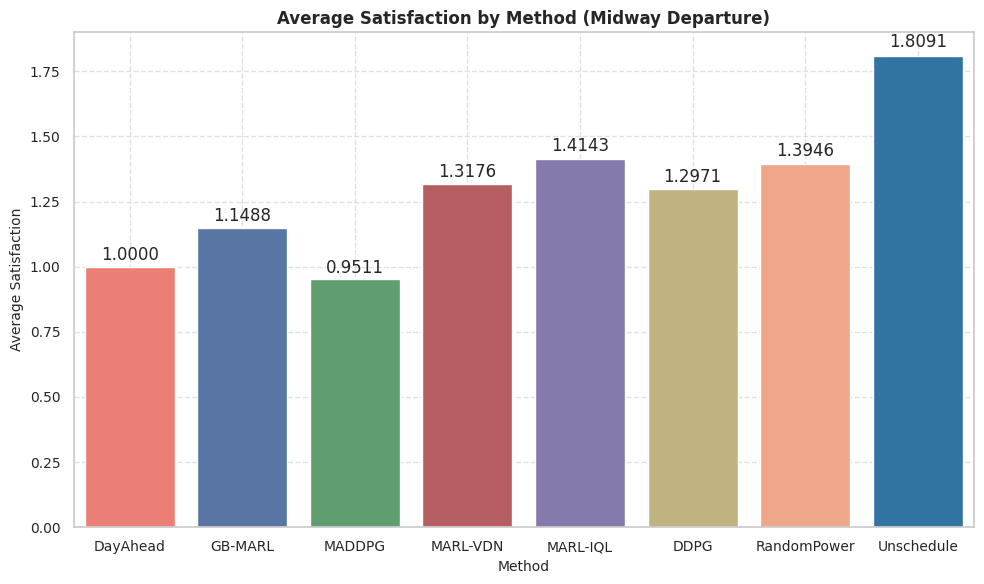

In [288]:
data_frames = DATA_FRAMES = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    satisfaction = calculate_midway_satisfaction_2(df, START_DATE_TIME, END_DATE_TIME, charging_records_df)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction 2 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 2 (old)

In [289]:
def calculate_midway_satisfaction_old_2(df, start_date, end_date):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    
    # calculate midway time for each requestID
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]
    midway_time = midway_time.dt.round('H')

    # calculate satisfaction2 for each requestID
    satisfaction2 = []
    for requestID, mid_time in midway_time.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[-1]['soc']  # SoC at departure (latest time)
        
        # Get SoC at the midway unexpected time
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        midway_soc = df[mid_time_index]['soc'].values[0]

        # Apply the formula from the image
        satisfaction_value = (midway_soc - soc_initial) / (soc_final - soc_initial)
        satisfaction2.append(satisfaction_value)
    
    return pd.Series(satisfaction2)


Average Satisfaction old 2 by Method:
---------------------------------
DayAhead: 0.4338
GB-MARL: -0.6673
MADDPG: -1.3443
MARL-VDN: -0.0971
MARL-IQL: 0.2246
DDPG: -0.3688
RandomPower: 0.3032
Unschedule: 1.0000


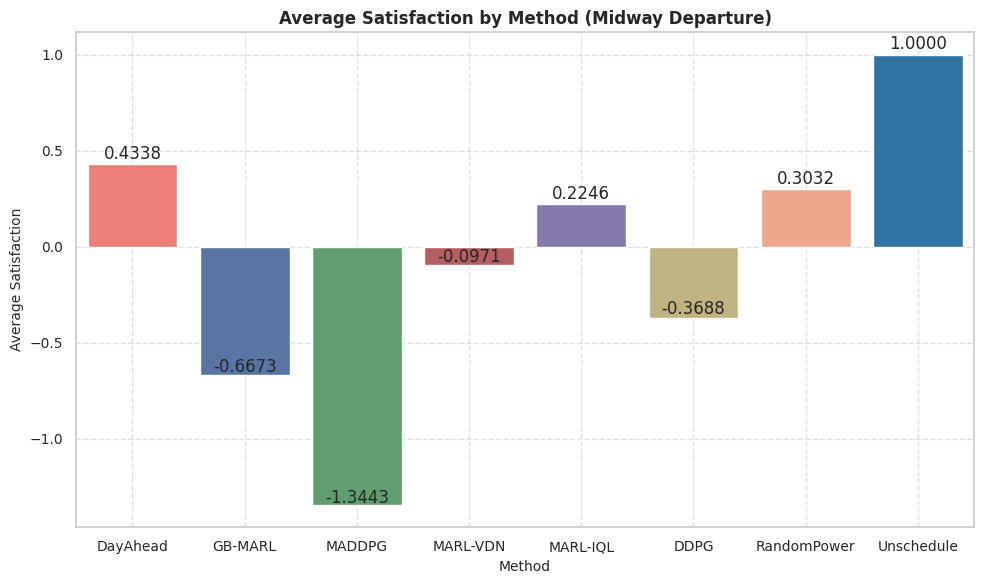

In [290]:
data_frames = DATA_FRAMES = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction_old_2(df, START_DATE_TIME, END_DATE_TIME)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction old 2 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 3

In [291]:
def calculate_midway_satisfaction_3(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]

    # calculate satisfaction2 for each requestID
    satisfactions = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = charging_records_df[charging_records_df['requestID'] == requestID]['departure_soc'].values[0]  # SoC at departure (latest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        actual_departure_soc = df[max_time_index]['soc'].values[0]

        # Apply the formula from the image
        r = 1 if actual_departure_soc >= soc_initial else 0
        satisfaction_value = (actual_departure_soc / soc_final) * r
        satisfactions.append(satisfaction_value)
    
    return pd.Series(satisfactions)


Average Satisfaction 3 by Method:
---------------------------------
DayAhead: 1.0000
GB-MARL: 1.0348
MADDPG: 0.9850
MARL-VDN: 1.0783
MARL-IQL: 1.1029
DDPG: 1.0741
RandomPower: 1.1024
Unschedule: 1.2095


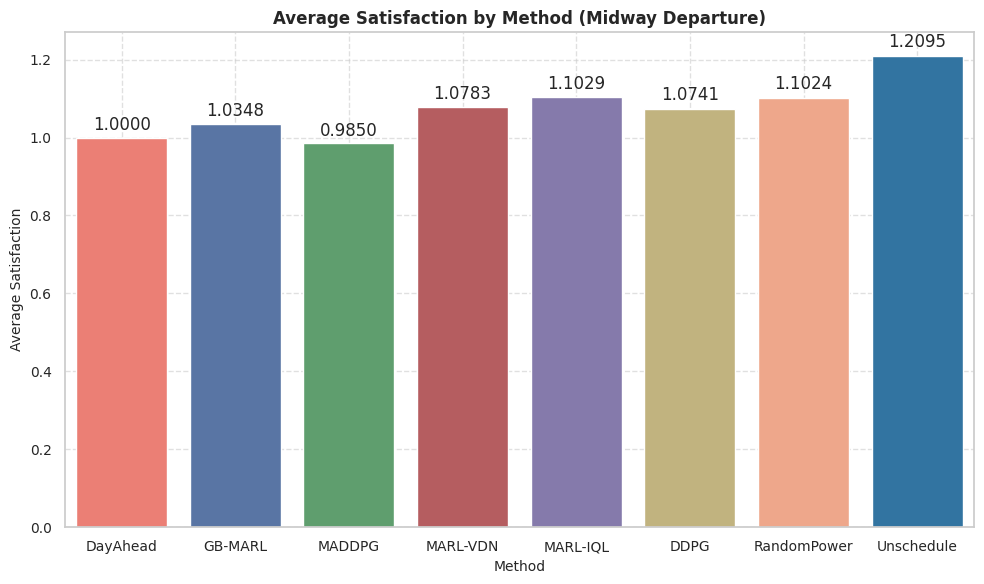

In [292]:
data_frames = DATA_FRAMES = []
for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    satisfaction = calculate_midway_satisfaction_3(df, start_datetime, end_datetime, charging_records_df)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction 3 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 3 (old)

In [293]:
def calculate_midway_satisfaction_old_3(df, start_date, end_date):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    
    # calculate midway time for each requestID
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]
    midway_time = midway_time.dt.round('H')

    # calculate satisfaction2 for each requestID
    satisfaction3 = []
    for requestID, mid_time in midway_time.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[-1]['soc']  # SoC at departure (latest time)
        
        # Get SoC at the midway unexpected time
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        midway_soc = df[mid_time_index]['soc'].values[0]

        # Apply the formula from the image
        r = 1 if midway_soc >= soc_initial else 0
        satisfaction_value = (midway_soc / soc_final) * r
        satisfaction3.append(satisfaction_value)
    
    return pd.Series(satisfaction3)

Average Satisfaction old 3 by Method:
---------------------------------
DayAhead: 0.7645
GB-MARL: 0.2569
MADDPG: 0.0271
MARL-VDN: 0.3928
MARL-IQL: 0.5485
DDPG: 0.4134
RandomPower: 0.5589
Unschedule: 1.0000


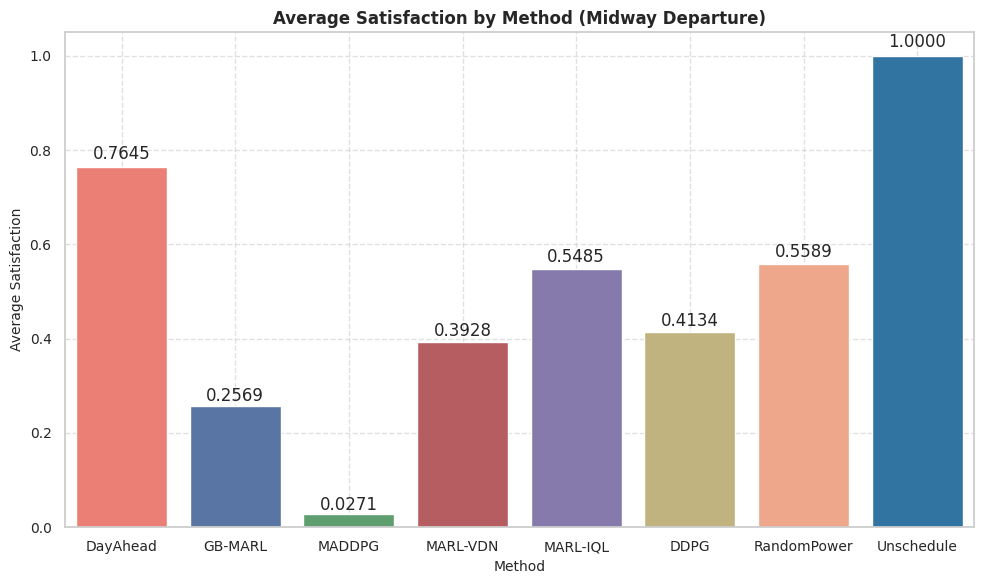

In [294]:
data_frames = DATA_FRAMES = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction_old_3(df, START_DATE_TIME, END_DATE_TIME)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction old 3 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 4

In [295]:
def calculate_midway_satisfaction_4(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]
    
    # calculate satisfaction2 for each requestID
    satisfactions = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        actual_departure_soc = df[max_time_index]['soc'].values[0]
        
        # Apply the formula from the image
        satisfaction_value = actual_departure_soc - soc_initial
        satisfactions.append(satisfaction_value)
    
    return pd.Series(satisfactions)


Average Satisfaction by Method:
---------------------------------
DayAhead: 0.3058
GB-MARL: 0.3297
MADDPG: 0.2946
MARL-VDN: 0.3600
MARL-IQL: 0.3768
DDPG: 0.3573
RandomPower: 0.3770
Unschedule: 0.4522


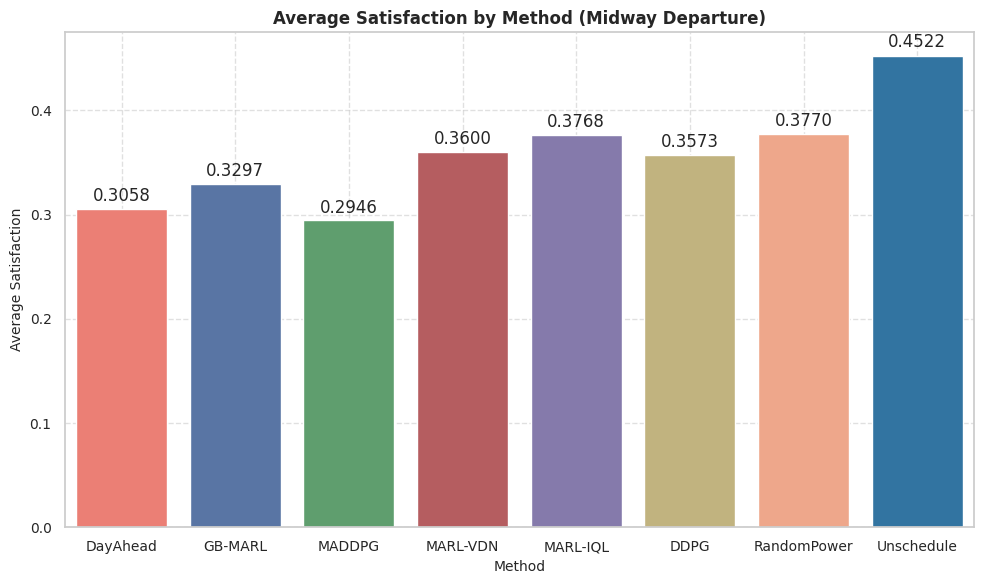

In [296]:
data_frames = DATA_FRAMES = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    satisfaction = calculate_midway_satisfaction_4(df, start_datetime, end_datetime, charging_records_df)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)

### Satisfication 4 (old)

In [297]:
def calculate_midway_satisfaction_old_4(df, start_date, end_date):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    
    # calculate midway time for each requestID
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]
    midway_time = midway_time.dt.round('H')

    # calculate satisfaction2 for each requestID
    satisfaction4 = []
    for requestID, mid_time in midway_time.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[-1]['soc']  # SoC at departure (latest time)
        
        # Get SoC at the midway unexpected time
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        midway_soc = df[mid_time_index]['soc'].values[0]

        # Apply the formula from the image
        satisfaction_value = (midway_soc - soc_initial)
        satisfaction4.append(satisfaction_value)
    
    return pd.Series(satisfaction4)


Average Satisfaction old 4 by Method:
---------------------------------
DayAhead: 0.1355
GB-MARL: -0.0707
MADDPG: -0.2062
MARL-VDN: 0.0208
MARL-IQL: 0.1115
DDPG: 0.0548
RandomPower: 0.1208
Unschedule: 0.4522


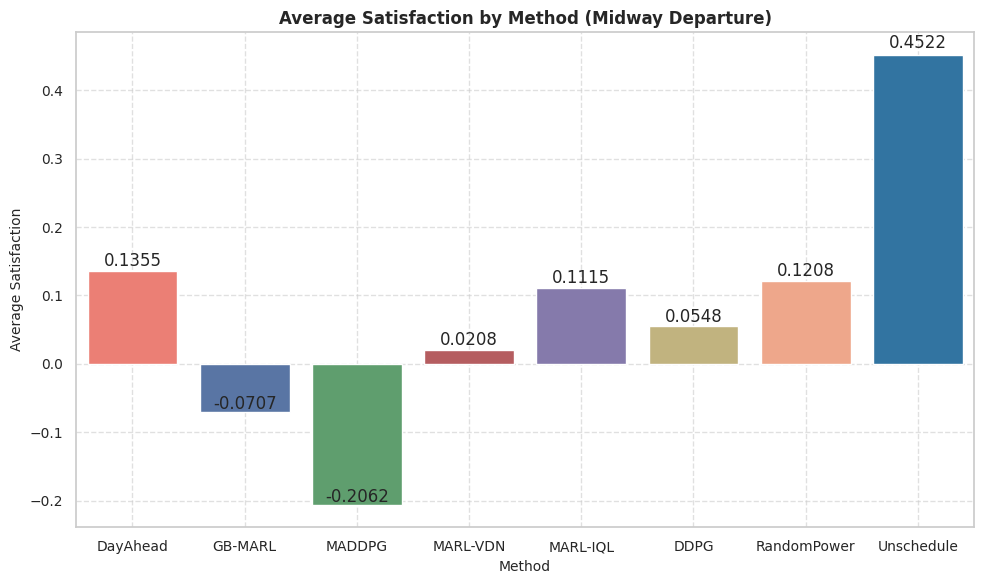

In [298]:
data_frames = DATA_FRAMES = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction_old_4(df, START_DATE_TIME, END_DATE_TIME)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction old 4 by Method:")
print('---------------------------------')
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

show_satisfaction(METHOD_NAMES, avg_satisfaction, COLORS)